In [1]:
import numpy as np
import matplotlib.pyplot as plt

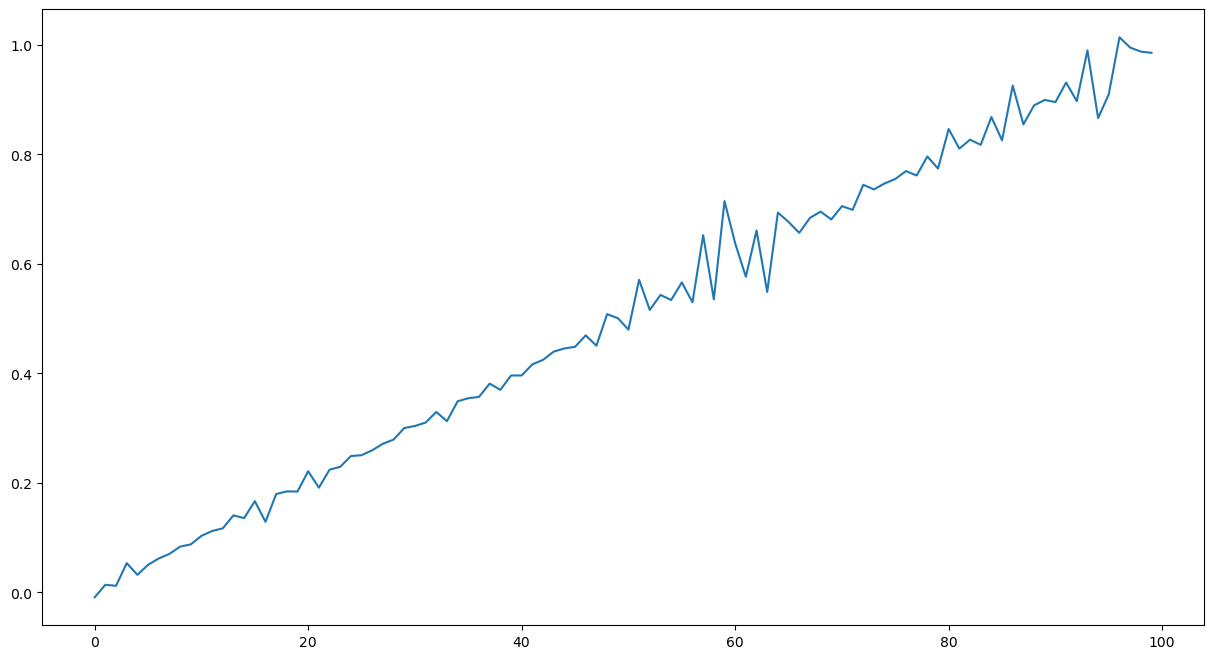

In [6]:
def gen_chaos(start, steps, func, add_id=True, id_scaling=1):
    res = np.zeros(steps)
    cur = start
    for ind in range(res.size):
        cur = func(cur)
        res[ind] = cur
    if add_id:
        res += id_scaling * np.arange(steps)
    return res

def f(x):
    eps_f = 1e-2
    det = (1.5 * x * np.sin(x**-2) - np.tan(x)) / (x+1)**4.5
    rand = np.random.random()
    return det + eps_f * rand
    # return np.log(x+1) / x**2 # np.log(x+1) / (3 ** np.sqrt(x+1)) + 0.0005 * x**1.3

def plot_chaos(seed=1):
    np.random.seed(seed)
    
    n = 100
    xs = np.arange(n)
    ys = gen_chaos(1, xs.size, f, id_scaling=0.01)
    # sigma_ys = 1e-2
    # ys2 = ys + np.random.normal(size=ys.shape, scale=sigma_ys)
    
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(xs, ys)
    # ax.plot(xs, ys2)

plot_chaos()

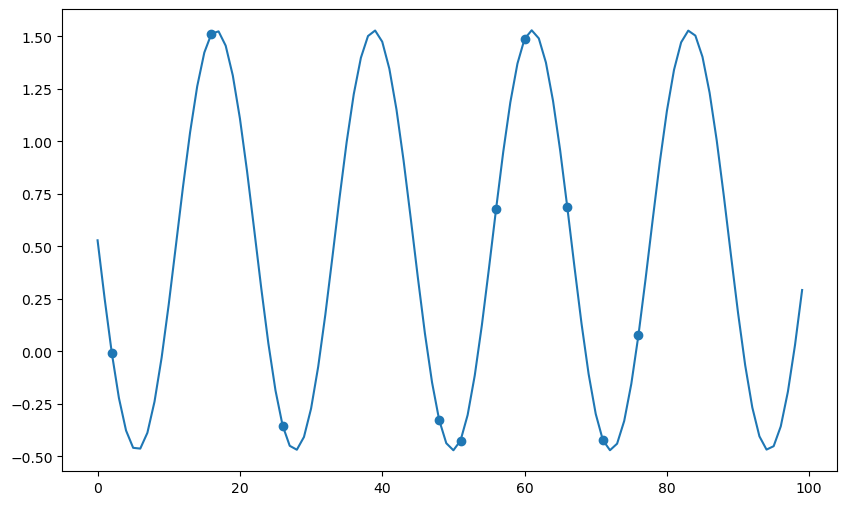

In [3]:
def f(x):
    eps = 0.3
    scale = MAX_N / 4
    return np.sin(scale * x) + np.random.randn(1)*eps


def sample_sin(N=30, MAX_N=100, seed=0):
    np.random.seed(seed)
    
    X = np.arange(MAX_N)
    Y = f(X)
    
    some_X = np.random.choice(X, N, replace=False)
    some_Y = Y[some_X]
    return X.reshape(-1, 1), Y.reshape(-1, 1), some_X.reshape(-1, 1), some_Y.reshape(-1, 1)


def plot_sampled_sin(X, Y, some_X, some_Y, figsize=(15,8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(X, Y)
    ax.scatter(some_X, some_Y)

MAX_N = 24

X, Y, some_X, some_Y = sample_sin(N=10)
plot_sampled_sin(X, Y, some_X, some_Y, figsize=(10,6))

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


# X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
# y = np.squeeze(X * np.sin(X))

# X_train, y_train = X[training_indices], y[training_indices]
X_train, y_train = some_X, some_Y
y = Y

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=200)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

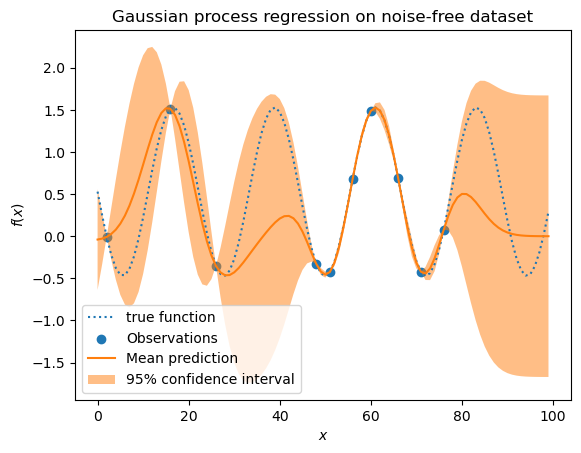

In [5]:
# plot GP

plt.plot(X, y, label=r"true function", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [6]:
######## Deterministic ########

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVR


# train_size = training_indices.size

# svr = GridSearchCV(
#     SVR(kernel="rbf", gamma=0.1),
#     param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
# )

kr = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)},
)

# kr = KernelRidge(kernel="rbf", gamma=0.1)
kr.fit(X_train, y_train)
kr_pred = kr.predict(X)

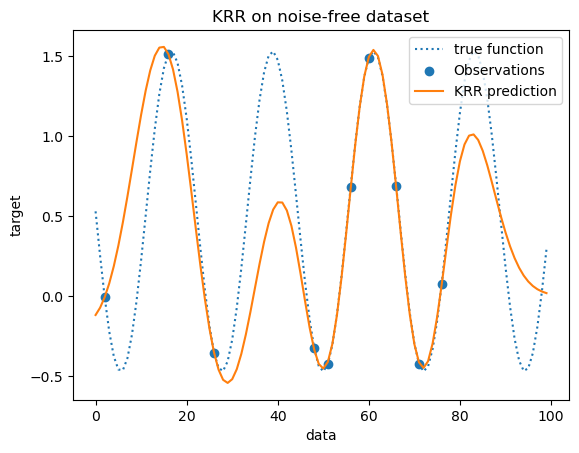

In [7]:
# plot KRR

plt.plot(X, y, label=r"true function", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, kr_pred, label="KRR prediction")
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("KRR on noise-free dataset")

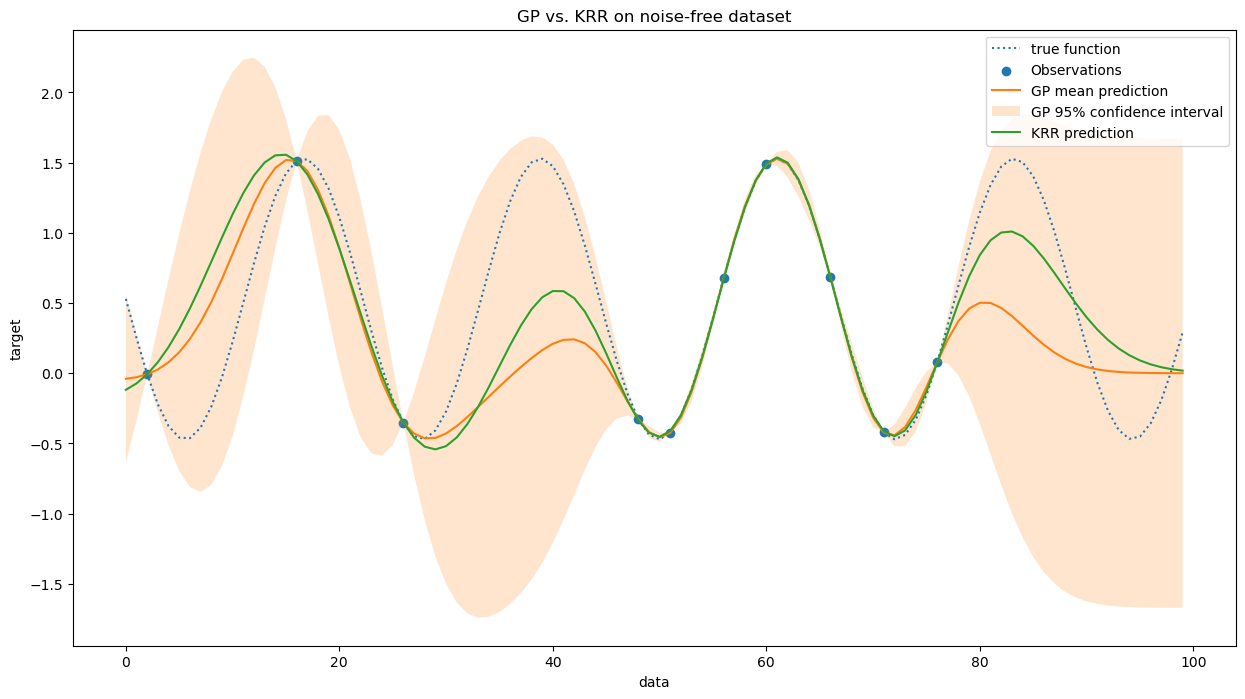

In [8]:
# plot both

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(X, y, label=r"true function", linestyle="dotted")
ax.scatter(X_train, y_train, label="Observations")

# GP
ax.plot(X, mean_prediction, label="GP mean prediction")
ax.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.2,
    label=r"GP 95% confidence interval",
)

# KRR
ax.plot(X, kr_pred, label="KRR prediction")

ax.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("GP vs. KRR on noise-free dataset")

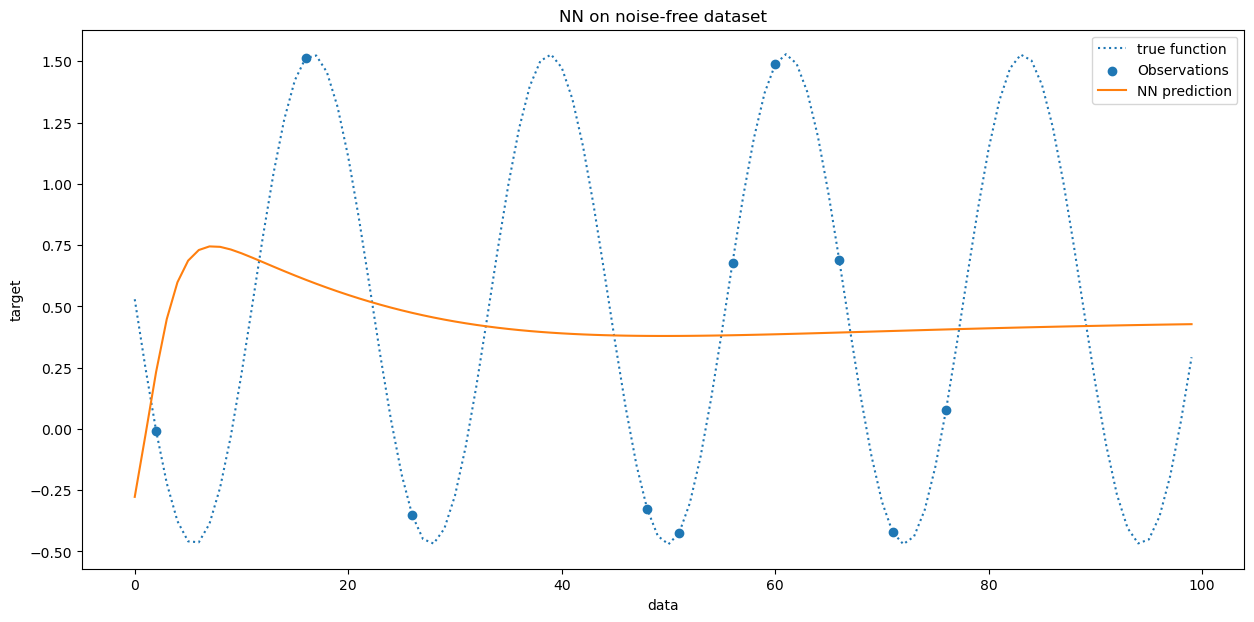

In [29]:
# sklearn NN test

from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(
    hidden_layer_sizes=(20),
    random_state=1,
    max_iter=20000,
    activation='tanh'
).fit(X_train, y_train.ravel())
nn_pred = regr.predict(X_test)


# plot

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(X, y, label=r"true function", linestyle="dotted")
ax.scatter(X_train, y_train, label="Observations")

ax.plot(X, nn_pred, label="NN prediction")

ax.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("NN on noise-free dataset")

In [37]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


# to tensors
# X_tensor, y_tensor = torch.Tensor(X), torch.Tensor(y)
# X_train_tensor, y_train_tensor = torch.Tensor(X_train), torch.Tensor(y_train)

N_test = 3

np.random.seed(0)
test_inds = np.random.choice(X.size, N_test, replace=False)
X_test, y_test = X[test_inds], y[test_inds]

(array([[26],
        [86],
        [ 2]]),
 array([[-0.35256892],
        [ 1.23164495],
        [-0.00735721]]))

In [43]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        # # extract only the last time step
        # x = x[:, -1, :]
        x = self.linear(x)
        return x


# model = MyModel()
# optimizer = optim.Adam(model.parameters())



# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


def train(dataset, model, loss_fn, optimizer):
    size = dataset.size
    model.train()
    for batch, (X, y) in enumerate(dataset):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataset, model, loss_fn):
    size = dataset.size
    num_batches = len(dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


dataset_train = list(zip(X_train, y_train))
dataset = list(zip(X_test, y_test))
# train(dataset, model, loss_fn, optimizer)
# test(dataset, model, loss_fn)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataset, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


AttributeError: partially initialized module 'torch._dynamo' has no attribute 'trace_rules' (most likely due to a circular import)

In [ ]:


# n_epochs = 20
# for epoch in range(n_epochs):
#     model.train()
#     for X_batch, y_batch in loader:
#         y_pred = model(X_batch)
#         loss = loss_fn(y_pred, y_batch)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     # Validation
#     if epoch % 100 != 0:
#         continue
#     model.eval()
#     with torch.no_grad():
#         y_pred = model(X_train)
#         train_rmse = np.sqrt(loss_fn(y_pred, y_train))
#         y_pred = model(X_test)
#         test_rmse = np.sqrt(loss_fn(y_pred, y_test))
#     print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))